In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import time


In [4]:
from chronos import BaseChronosPipeline


In [5]:
# Завантаження даних
df = pd.read_csv('/Users/vladislavpleshko/Documents/VS Code/before/amazinum/data/Electricity Consumption and Production.csv',
                 parse_dates=['DateTime'], index_col='DateTime')
df_daily = df['Consumption'].resample('D').mean().dropna()


In [36]:
def calculate_metrics(test_series: pd.Series, forecast_series: pd.Series):
    """
    Calculate metrics for the forecasted values

    Args:
        test_series (pd.Series): Time Series for evaluation
        forecasted_series (pd.Series): Forecasted values

    Returns:
        - mape: Mean Absolute Percentage Error between test vs forecast
        - mae: Mean Absolute Error between test vs forecast
        - mse: Mean Squared Error between test vs forecast
    """

    mape = mean_absolute_percentage_error(test_series, forecast_series)
    mae = mean_absolute_error(test_series, forecast_series)
    mse = mean_squared_error(test_series, forecast_series)

    return mape, mae, mse


def visualize_forecast(
    train_series: pd.Series,
    test_series: pd.Series,
    forecast_series: pd.Series,
    title: str="Forecasting predictions"
):
    """
    Visualize forecasting predictions with metrics

    Args:
        train_series (pd.Series): Historircal time series
        test_series (pd.Series): Time Series for evaluation
        forecasted_series (pd.Series): Forecasted values
        title (str): Plot title
    """

    # Calculate metrics
    mape, mae, mse = calculate_metrics(test_series, forecast_series)

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot each series
    train_series.plot(ax=ax, label="Train series")
    test_series.plot(ax=ax, label="Test Series")
    forecast_series.plot(ax=ax, label="Predicted Series")

    # Plotting titles and labels
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Forecast results")
    ax.grid(True)
    ax.legend(title="Series")

    # Add the metrics as text on the plot
    metrics_text = f"MAPE: {mape:.2f}%\nMAE: {mae:.2f}\nMSE: {mse:.2f}"
    ax.text(0.99, 0.95, metrics_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=1'))

    plt.tight_layout()
    plt.show()


Прогноз на 15 днів:
Модель: amazon/chronos-bolt-base | Час прогнозування: 5.501 секунд


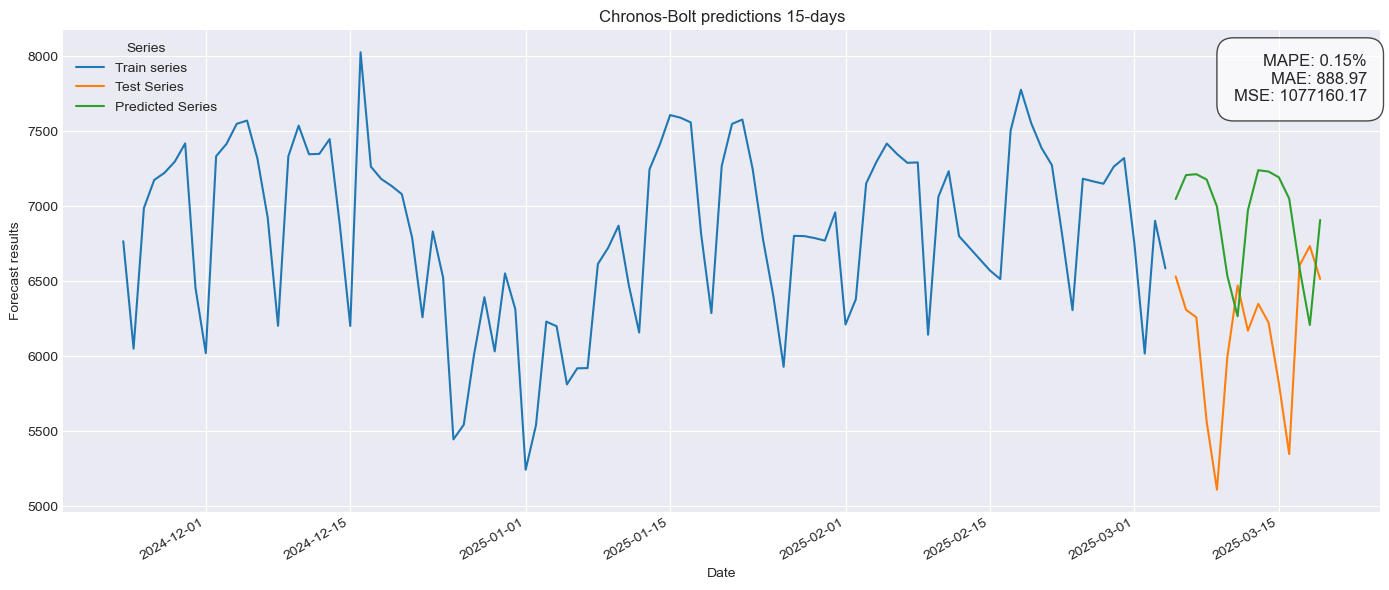

Прогноз на 30 днів:
Модель: amazon/chronos-bolt-base | Час прогнозування: 5.487 секунд


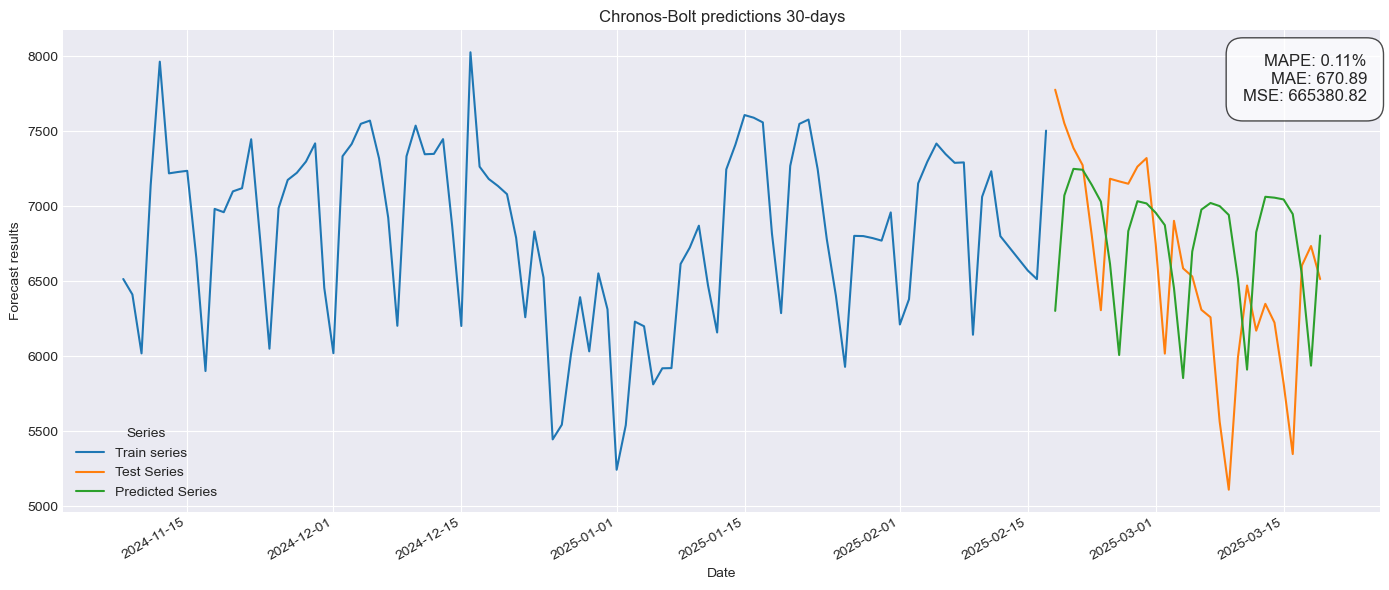

Прогноз на 45 днів:
Модель: amazon/chronos-bolt-base | Час прогнозування: 5.493 секунд


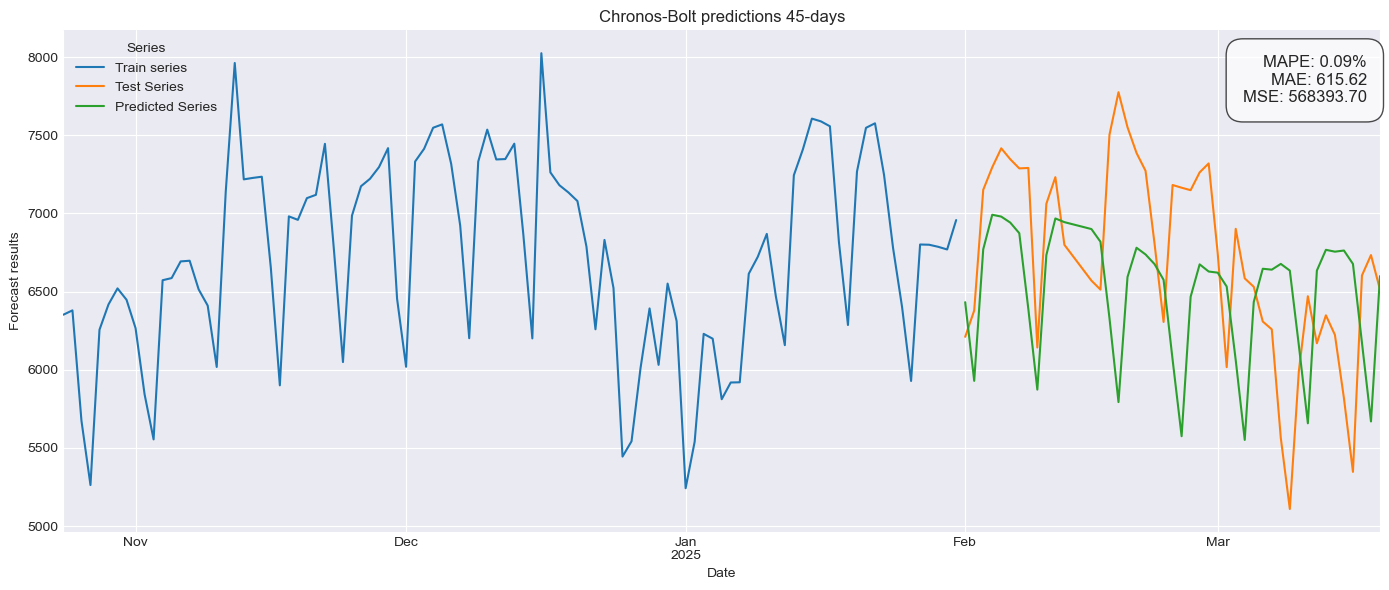


Зведена інформація по перфомансу:
                      model   k      MAPE         MAE           MSE  Time (s)
0  amazon/chronos-bolt-base  15  0.152283  888.965204  1.077160e+06  5.500598
1  amazon/chronos-bolt-base  30  0.107535  670.892412  6.653808e+05  5.487056
2  amazon/chronos-bolt-base  45  0.092988  615.615736  5.683937e+05  5.492860


In [45]:
def run_chronos_forecasting(df_daily, k):
    train_series = df_daily.iloc[:-k]
    test_series  = df_daily.iloc[-k:]
    train_values = torch.tensor(train_series.values, dtype=torch.float32)

    # Ініціалізуємо модель
    model_name = "amazon/chronos-bolt-base"
    chronos_model = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-bolt-base",
        device_map="cpu",
        torch_dtype=torch.bfloat16,
    )

    # Прогноз
    start_time = time.time()
    forecast = chronos_model.predict_quantiles(
        context=train_values,
        prediction_length=len(test_series)
    )
    elapsed = time.time() - start_time
    print(f"Модель: {model_name} | Час прогнозування: {elapsed:.3f} секунд")

    # Обробка результату
    mean_forecast = forecast[1][0].tolist()
    forecast_series = pd.Series(mean_forecast, index=test_series.index)

    # Візуалізація
    visualize_forecast(
        train_series=train_series[-100:],
        test_series=test_series,
        forecast_series=forecast_series,
        title=(f"Chronos-Bolt predictions {k}-days")
    )

    # Повертаємо метрики
    mape, mae, mse = calculate_metrics(test_series, forecast_series)
    return {"model": model_name, "k": k, "MAPE": mape, "MAE": mae, "MSE": mse, "Time (s)": elapsed}

# Цикл прогнозування з метриками
results = []
for k in [15, 30, 45]:
    print(f"Прогноз на {k} днів:")
    res = run_chronos_forecasting(df_daily, k)
    results.append(res)

# Вивід зведеної інформації
results_df = pd.DataFrame(results)
print("\nЗведена інформація по перфомансу:")
print(results_df)
